In [1]:
from fretbursts import *
sns = init_notebook()

 - Optimized (cython) burst search loaded.
 - Optimized (cython) photon counting loaded.
--------------------------------------------------------------
 You are running FRETBursts (version 0.6.5+7.g10955f6).

 If you use this software please cite the following paper:

   FRETBursts: An Open Source Toolkit for Analysis of Freely-Diffusing Single-Molecule FRET
   Ingargiola et al. (2016). http://dx.doi.org/10.1371/journal.pone.0160716 

--------------------------------------------------------------


In [2]:
full_fname='LS3.h5'
d = loader.photon_hdf5(full_fname)

In [3]:
d.time_max

3600.0527149892509

In [4]:
d.det_t

[array([1, 0, 0, ..., 1, 1, 1], dtype=uint8)]

In [5]:
print("Detector    Counts")
print("--------   --------")
for det, count in zip(*np.unique(d.det_t, return_counts=True)):
    print("%8d   %8d" % (det, count))

Detector    Counts
--------   --------
       0   11783630
       1   14918897


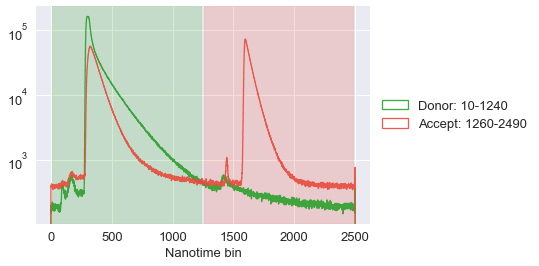

In [6]:
bpl.plot_alternation_hist(d)

In [7]:
loader.alex_apply_period(d)

# Total photons (after ALEX selection):    26,671,945
#  D  photons in D+A excitation periods:   14,906,003
#  A  photons in D+A excitation periods:   11,765,942
# D+A photons in  D  excitation period:    21,113,483
# D+A photons in  A  excitation period:     5,558,462



In [8]:
d.calc_bg(fun=bg.exp_fit, time_s=10, tail_min_us='auto', F_bg=2)

 - Calculating BG rates ... [DONE]


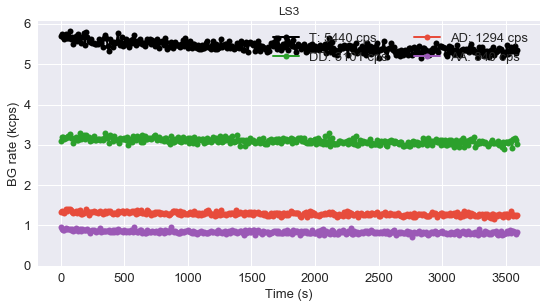

In [9]:
dplot(d, timetrace_bg)

(-50, 50)

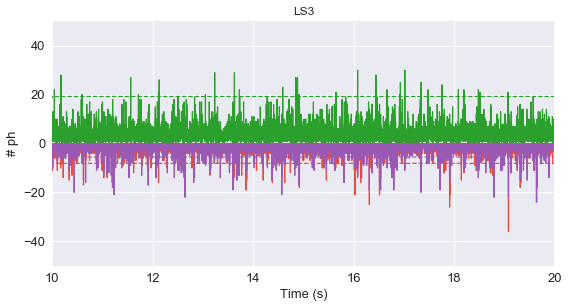

In [10]:
dplot(d, timetrace)
xlim(10, 20)
ylim(-50, 50)


In [11]:
d.burst_search()

 - Performing burst search (verbose=False) ...[DONE]
 - Calculating burst periods ...[DONE]
 - Counting D and A ph and calculating FRET ... 
   - Applying background correction.
   [DONE Counting D/A]


In [12]:
ph = d.get_ph_times()
ns=d.nanotimes

len(ph),len(ns[0])

(26671945, 26671945)

In [13]:
import numpy as np
print(np.mean(d.TT),len(d.TT[0]))

0.000306519689847 360


In [14]:
ds = d.select_bursts(select_bursts.naa, th1=5, computefret=False)
ds = ds.select_bursts(select_bursts.size, th1=30)
ds = ds.fuse_bursts(ms=0)

 - - - - - CHANNEL  1 - - - - 
 --> END Fused 8 bursts (0.4%, 2 iter)

 - Counting D and A ph and calculating FRET ... 
   - Applying background correction.
   [DONE Counting D/A and FRET]


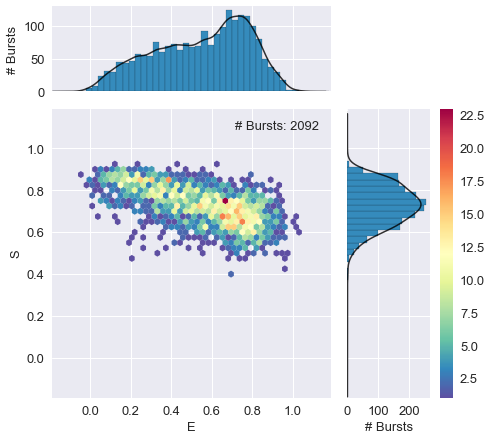

In [15]:
alex_jointplot(ds)

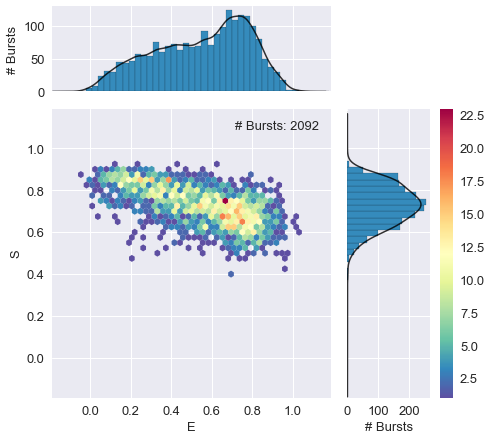

In [16]:
alex_jointplot(ds)

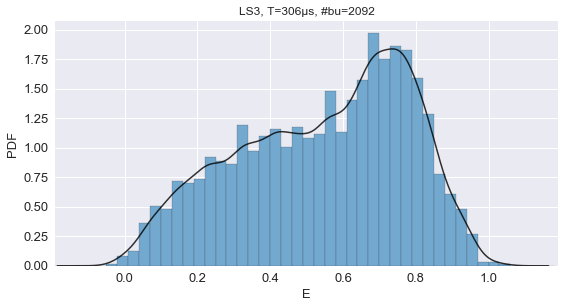

In [17]:
dplot(ds, hist_fret, show_kde=True)

In [18]:
nanotimes = d.nanotimes[0]
nanotimes_d = nanotimes[d.get_D_em()]
nanotimes_a = nanotimes[d.get_A_em()]

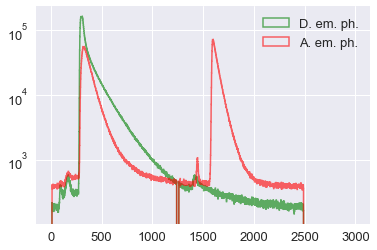

In [19]:
hist_params = dict(bins=range(3000), histtype='step', alpha=0.6, lw=1.5)
#hist(nanotimes, color='k', label='Total ph.', **hist_params)
hist(nanotimes_d, color='g', label='D. em. ph.', **hist_params)
hist(nanotimes_a, color='r', label='A. em. ph.', **hist_params)
plt.legend()
plt.yscale('log')

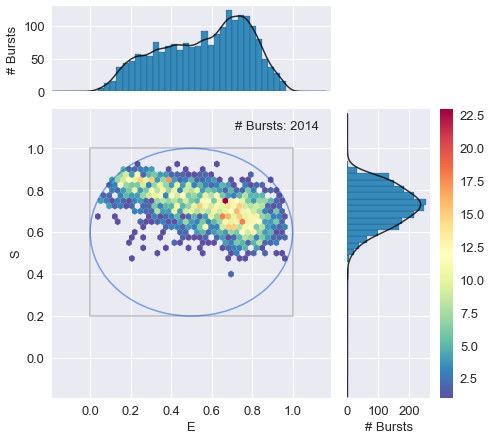

In [20]:
roi = dict(E1=0, E2=1, S1=0.2, S2=1, rect=False)
d_fret_mix = ds.select_bursts(select_bursts.ES, **roi)
g = alex_jointplot(d_fret_mix)
bpl.plot_ES_selection(g.ax_joint, **roi);

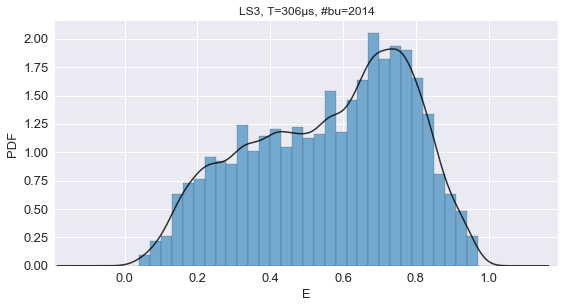

In [21]:
dplot(d_fret_mix, hist_fret, show_kde=True)

In [22]:
from fretbursts.phtools.burstsearch import Burst, Bursts
times = d.ph_times_m[0]  # timestamps array
bursts = d_fret_mix.mburst[0]
print('\nNumber of bursts:', bursts.num_bursts)


Number of bursts: 2014


In [23]:
time_bin = 0.5e-3  # 0.5 ms
time_bin_clk = time_bin / ds.clk_p

sub_bursts_list = []
for burst in bursts:
    # Compute binning of current bursts
    bins = np.arange(burst.start, burst.stop + time_bin_clk, time_bin_clk)
    counts, _ = np.histogram(times[burst.istart:burst.istop+1], bins)
    
    # From `counts` in each bin, find start-stop times and indexes (sub-burst).
    # Note that start and stop are the min and max timestamps in the bin,
    # therefore they are not on the bin edges. Also the burst width is not
    # exactly equal to the bin width.
    sub_bursts_l = []
    sub_start = burst.start
    sub_istart = burst.istart
    for count in counts:
        # Let's skip bins with 0 photons
        if count == 0:
            continue
            
        sub_istop = sub_istart + count - 1
        sub_bursts_l.append(Burst(istart=sub_istart, istop=sub_istop,
                                  start=sub_start, stop=times[sub_istop]))
        
        sub_istart += count 
        sub_start = times[sub_istart]
    
    sub_bursts = Bursts.from_list(sub_bursts_l)
    assert sub_bursts.num_bursts > 0
    assert sub_bursts.width.max() < time_bin_clk
    sub_bursts_list.append(sub_bursts)

In [24]:
len(sub_bursts_list)

2014

In [25]:
d_fret_mix.num_bursts

array([2014])

In [26]:
iburst = 100
print('Sub-bursts from burst %d:' % iburst)
sub_bursts_list[iburst]

Sub-bursts from burst 100:


,istart,istop,start,stop
0,1268688,1268706,2615707350,2615714555
1,1268707,1268741,2615715860,2615722921
2,1268742,1268752,2615723463,2615727634


In [27]:
(869175247-869183230)*ds.clk_p,ds.clk_p

(-0.0004989125543722814, 6.249687515624219e-08)

In [28]:
439824-439803

21

In [29]:
nanotimes[2:9]

array([1589,  278, 1754,  282,  537,  311,  340], dtype=uint16)

In [30]:
bursts = sub_bursts_list[0]
bursts

,istart,istop,start,stop
0,2994,3021,7121134,7129046
1,3022,3035,7129239,7133990


In [43]:
mask_dd = d.get_ph_mask(ph_sel=Ph_sel(Dex='Dem'))   # donor excitation, donor emission
mask_ad = d.get_ph_mask(ph_sel=Ph_sel(Dex='Aem'))   # donor excitation, acceptor emission
mask_aa = d.get_ph_mask(ph_sel=Ph_sel(Aex='Aem'))   # acceptor excitation, acceptor emission
from fretbursts.phtools.burstsearch import count_ph_in_bursts

bursts=d_fret_mix.mburst[0]
counts_dd = count_ph_in_bursts(bursts, mask_dd)
counts_ad = count_ph_in_bursts(bursts, mask_ad)
counts_aa = count_ph_in_bursts(bursts, mask_aa)
e=counts_ad / (counts_dd + counts_ad)
bursts.num_burst

AttributeError: 'BurstsGap' object has no attribute 'num_burst'

In [32]:
(counts_ad / (counts_dd + counts_ad)).tolist()

[0.625, 0.18181818181818182]

In [33]:
import fretbursts
l=fretbursts.burstlib_ext.calc_mean_lifetime(d_fret_mix,250,1200,ph_sel=Ph_sel(Dex='DAem'))

In [38]:
lt=((l[0]*2.5e-2)-2.1)/4.1
gamma=0.34        
beta=1.42
DexDirAem=0.08
Dch2Ach=0.07 
fE=fretbursts.fretmath.correct_E_gamma_leak_dir(d_fret_mix.E[0],gamma, leakage=Dch2Ach, dir_ex_t=DexDirAem)

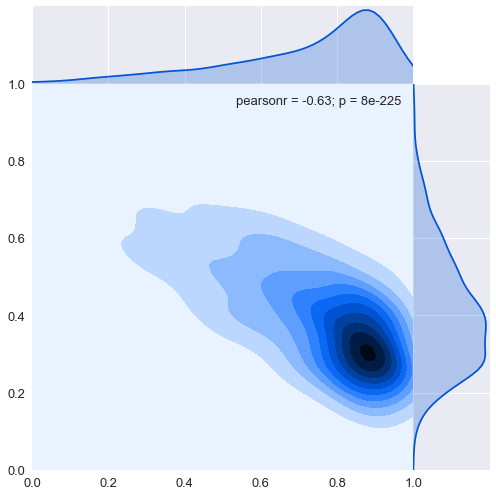

In [39]:
sns.jointplot(fE, lt, kind="kde", size=7, space=0,ylim=(0,1),xlim=(0,1))

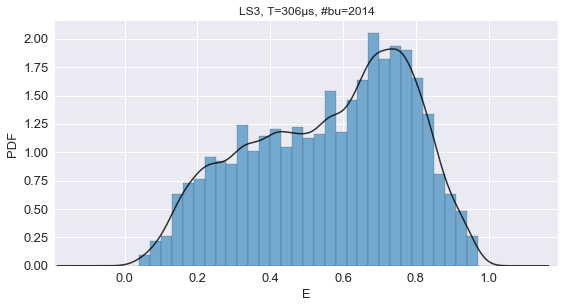

In [36]:
dplot(d_fret_mix, hist_fret, show_kde=True)

In [37]:

import scipy.io as sio
from array import array

Fsel=array("d")
for i in fE:
    if i<0.999 and i >0.001:
        Fsel.append(i)
sio.savemat('fret.mat', {'fret':Fsel})